In [9]:
import os
import cv2
import glob
import h5py
import shutil
import keras
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as augment
import tensorflow as tf
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path

from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,EarlyStopping,TensorBoard,ReduceLROnPlateau,CSVLogger,LearningRateScheduler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
color = sns.color_palette()
%matplotlib inline

In [10]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [11]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [12]:
train_data = '../input/chest_xray/chest_xray/train/'
val_data = '../input/chest_xray/chest_xray/val/'
test_data = '../input/chest_xray/chest_xray/test/'

normal_data_dir = '../input/chest_xray/chest_xray/train/NORMAL/'
pneumonia_data_dir = '../input/chest_xray/chest_xray/train/PNEUMONIA/'


In [13]:
augs = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_augs = ImageDataGenerator(rescale=1./255)

train_gen = augs.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

val_gen = val_augs.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

test_gen = val_augs.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
base_tmodel = VGG16(weights='imagenet', include_top=False , input_shape=(224,224,3))

for layer in base_tmodel.layers:
    layer.trainable = False

x = base_tmodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
clf = Dense(1, activation='sigmoid')(x)
tmodel = Model(base_tmodel.input,clf)
tmodel.summary()

plot_model(tmodel, to_file='tmodel_architecture.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=1, 
    min_lr=0.0001
)

callbacks = [checkpoint,tensorboard,earlystop,csvlogger,reduce]

In [20]:
tmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = tmodel.fit_generator(
    train_gen,
    epochs=75,
    steps_per_epoch=30,
    validation_data=test_gen,
    validation_steps=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 19s 619ms/step - loss: 0.1898 - acc: 0.9250 - val_loss: 0.2645 - val_acc: 0.9125

Epoch 00001: val_loss did not improve from 0.69053
Epoch 2/75
30/30 [==============================] - 16s 517ms/step - loss: 0.1536 - acc: 0.9417 - val_loss: 0.3017 - val_acc: 0.8875

Epoch 00002: val_loss did not improve from 0.69053
Epoch 3/75
30/30 [==============================] - 17s 580ms/step - loss: 0.1747 - acc: 0.9292 - val_loss: 0.2664 - val_acc: 0.8875

Epoch 00003: val_loss did not improve from 0.69053
Epoch 4/75
30/30 [==============================] - 17s 559ms/step - loss: 0.2257 - acc: 0.9042 - val_loss: 0.3323 - val_acc: 0.8875

Epoch 00004: val_loss did not improve from 0.69053
Epoch 5/75
30/30 [==============================] - 16s 523ms/step - loss: 0.2441 - acc: 0.8917 - val_loss: 0.2775 - val_acc: 0.9000

Epoch 00005: val_loss did not improve from 0.69053
Epoch 6/75
30/30 [==============================] - 17s 562ms/step - loss: 

30/30 [==============================] - 16s 539ms/step - loss: 0.1324 - acc: 0.9479 - val_loss: 0.3606 - val_acc: 0.8583

Epoch 00042: val_loss did not improve from 0.69053

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
Epoch 43/75
30/30 [==============================] - 16s 530ms/step - loss: 0.1687 - acc: 0.9333 - val_loss: 0.2967 - val_acc: 0.9000

Epoch 00043: val_loss did not improve from 0.69053
Epoch 44/75
30/30 [==============================] - 17s 554ms/step - loss: 0.1528 - acc: 0.9500 - val_loss: 0.2832 - val_acc: 0.9125

Epoch 00044: val_loss did not improve from 0.69053
Epoch 45/75
30/30 [==============================] - 18s 615ms/step - loss: 0.1451 - acc: 0.9438 - val_loss: 0.3365 - val_acc: 0.8750

Epoch 00045: val_loss did not improve from 0.69053
Epoch 46/75
30/30 [==============================] - 15s 505ms/step - loss: 0.1596 - acc: 0.9354 - val_loss: 0.2619 - val_acc: 0.8958

Epoch 00046: val_loss did not improve from 0.69053


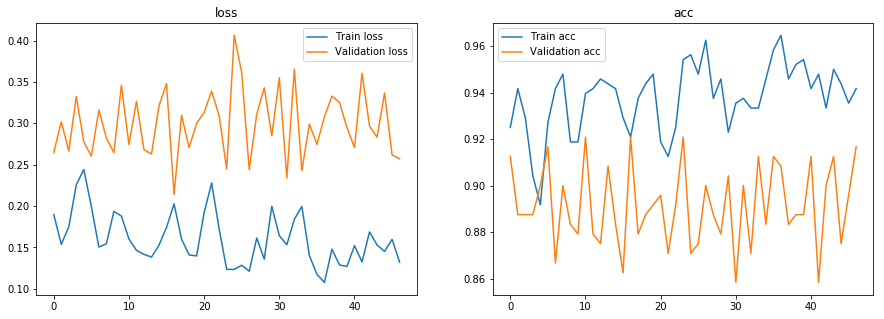

In [21]:
show_final_history(history)

In [22]:
tmodel_eval = tmodel.evaluate_generator(test_gen)
print("Tmodel: Evaluation: Test Loss", tmodel_eval[0])
print("Tmodel: Test Accuracy",tmodel_eval[1])

Tmodel: Evaluation: Test Loss 0.28903113501385236
Tmodel: Test Accuracy 0.905448717948718


In [23]:
tmodel_json = tmodel.to_json()
with open("tmodel.json","w") as json_file:
    json_file.write(tmodel_json)
    
tmodel.save("tmodel.h5")

In [24]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-01-26 17:38:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.248.161, 52.45.111.123, 54.174.228.92, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.248.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2019-01-26 17:38:44 (47.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://0e84902d.ngrok.io
